# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [78]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [79]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [80]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-05 09:00:00+09:00,51291.390625,51422.421875,50362.011719,50465.480469,0,0.0,0.0
2025-11-05 09:15:00+09:00,50512.878906,50601.730469,50245.941406,50260.410156,0,0.0,0.0
2025-11-05 09:30:00+09:00,50271.730469,50387.929688,50124.710938,50203.128906,0,0.0,0.0
2025-11-05 09:45:00+09:00,50202.121094,50360.988281,50163.609375,50197.871094,0,0.0,0.0
2025-11-05 10:00:00+09:00,50202.019531,50233.019531,49988.230469,50054.988281,0,0.0,0.0
2025-11-05 10:15:00+09:00,50034.191406,50034.679688,49516.421875,49588.058594,0,0.0,0.0
2025-11-05 10:30:00+09:00,49589.601562,49701.539062,49301.550781,49336.371094,0,0.0,0.0
2025-11-05 10:45:00+09:00,49349.761719,49592.281250,49325.558594,49437.460938,0,0.0,0.0
2025-11-05 11:00:00+09:00,49462.960938,49462.960938,49242.820312,49333.691406,0,0.0,0.0


## 前日終値の取得

In [81]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-29 00:00:00+09:00    51307.648438
2025-10-30 00:00:00+09:00    51325.609375
2025-10-31 00:00:00+09:00    52411.339844
2025-11-04 00:00:00+09:00    51497.199219
2025-11-05 00:00:00+09:00    49800.480469
Name: Close, dtype: float64


Date
2025-11-04 00:00:00+09:00    51497.199219
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [82]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-205.81


## ローソク足チャート（小さいサイズ）

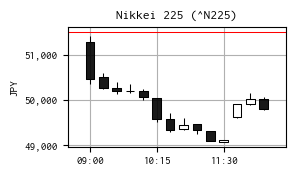

In [83]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [84]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [85]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-04 09:00:00+09:00,154.203995,154.397003,154.192001,154.350006,0,0.0,0.0
2025-11-04 09:15:00+09:00,154.348999,154.354996,154.253006,154.298004,0,0.0,0.0
2025-11-04 09:30:00+09:00,154.298004,154.320999,154.225998,154.302994,0,0.0,0.0
2025-11-04 09:45:00+09:00,154.302994,154.362000,154.270996,154.332993,0,0.0,0.0
2025-11-04 10:00:00+09:00,154.332993,154.412003,154.306000,154.369995,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-05 12:15:00+09:00,153.363998,153.369003,153.302994,153.367004,0,0.0,0.0
2025-11-05 12:30:00+09:00,153.363007,153.445007,153.348007,153.436996,0,0.0,0.0
2025-11-05 12:45:00+09:00,153.440002,153.565994,153.432999,153.505997,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [86]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-05 09:00:00+09:00,333.965303,334.818465,327.913989,328.587688
2025-11-05 09:15:00+09:00,329.076289,329.655130,327.337271,327.431530
2025-11-05 09:30:00+09:00,327.761501,328.519096,326.802963,327.314232
2025-11-05 09:45:00+09:00,327.615237,328.651993,327.363913,327.587502
2025-11-05 10:00:00+09:00,327.864920,328.067378,326.468682,326.904672
2025-11-05 10:15:00+09:00,326.862757,326.865947,323.480279,323.948266
2025-11-05 10:30:00+09:00,324.129880,324.861532,322.247109,322.474704
2025-11-05 10:45:00+09:00,322.206297,323.789716,322.048274,322.778888
2025-11-05 11:00:00+09:00,322.842103,322.842103,321.405257,321.998367


### 前日の終値のドル円レートから、前日の終値のドル換算

In [87]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-04 15:15:00+09:00


np.float64(153.55299377441406)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 335.3708576623713


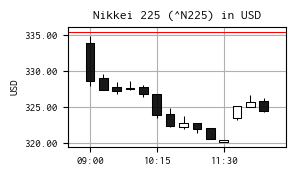

In [88]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()